In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
base_path = "data"
train = pd.read_csv(f'{base_path}/train.csv.zip', index_col="ID")
test = pd.read_csv(f'{base_path}/test.csv.zip', index_col="ID")
submission = pd.read_csv(f'{base_path}/sample_submission.csv.zip', index_col="ID")

In [3]:
cat_col = train.select_dtypes(include="object").columns
train[cat_col] = train[cat_col].astype("category")
test[cat_col] = test[cat_col].astype("category")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 0 to 8417
Columns: 377 entries, y to X385
dtypes: category(8), float64(1), int64(368)
memory usage: 11.9 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 1 to 8416
Columns: 376 entries, X0 to X385
dtypes: category(8), int64(368)
memory usage: 11.9 MB



### CatBoost 주요 파라미터
* cat_features : 범주형 변수 인덱스 값
* loss_function : 손실 함수
* eval_metric : 평가 메트릭
* iterations : 머신러닝 중 만들어질 수 있는 트리의 최대 개수 (alias : num_boost_round, n_estimators, num_trees)
* learning_rate : 학습률을 지정
* subsample : 배깅을 위한 서브샘플 비율을 지정
* max_leaves : 최종 트리의 최대 리프 개수
* https://catboost.ai/en/docs/references/training-parameters/common

In [6]:
# !pip install catboost

In [7]:
# catboost 의 회귀 알고리즘의 기본 metric 은 RMSE 입니다.
import catboost

model_cat = catboost.CatBoostRegressor(eval_metric='R2',
                                       cat_features=cat_col.tolist(), 
                                       logging_level="Silent")

model_cat

https://catboost.ai/en/docs/references/training-parameters/common#grow_policy

In [8]:
# SymmetricTree - 대칭트리
# Lossguide - 리프별 
# Depthwise - 깊이별
from scipy.stats import randint
from sklearn.utils.fixes import loguniform

param_grid = {
    'n_estimators': randint(100, 300),
    'depth': randint(1, 5),
    'learning_rate': loguniform(1e-3, 0.1),
    'min_child_samples': randint(10, 40),
    'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']
}

param_grid

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x1260fe440>,
 'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x126f2b8b0>,
 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x126f48580>,
 'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x126f492d0>,
 'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']}

In [9]:
# randomized_search
result = model_cat.randomized_search(param_grid, 
                                     train.drop(columns="y"), train["y"], cv=3, n_iter=10, 
                                     verbose=False)

In [10]:
# R2-mean
df_result = pd.DataFrame(result)
df_result.loc[["train-R2-mean", "test-R2-mean"]]

,params,cv_results
train-R2-mean,NaN,"[-54.6176944240954, -47.27053960629854, -40.90..."
test-R2-mean,NaN,"[-54.768422101525935, -47.40785812263277, -41...."


<Axes: >

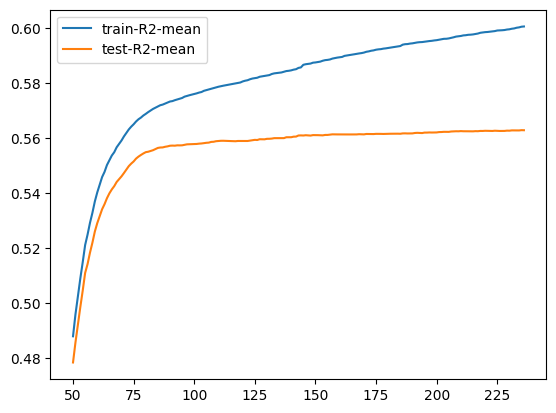

In [11]:
pd.DataFrame({"train-R2-mean": df_result.loc["train-R2-mean", "cv_results"],
              "test-R2-mean": df_result.loc["test-R2-mean", "cv_results"]
              })[50:].plot()

In [12]:
# fit
model_cat.fit(train.drop(columns="y"), train["y"])

In [13]:
y_pred_cat = model_cat.predict(test)
y_pred_cat[:5]

array([ 90.9845905 , 107.54915399,  91.86066384,  77.35622564,
       111.1031797 ])

In [14]:
model_cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'R2',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 237,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy

In [15]:
score_cat = model_cat.best_score_["learn"]["R2"]
score_cat

0.5964161236670449

In [16]:
submission["y"] = y_pred_cat

https://www.kaggle.com/competitions/mercedes-benz-greener-manufacturing/submissions

In [17]:
file_name = f'{base_path}/sub_cat_{score_cat:.5f}.csv'
file_name

'data/sub_cat_0.59642.csv'

In [18]:
submission.to_csv(file_name)
pd.read_csv(file_name).head(2)

,ID,y
0,1,90.984591
1,2,107.549154
